### Train with CNN + Transformer Tweak and Enhancement with Large Datasets
The CNN-Transformer model is indeed capturing some of the main features, but as you've noticed, it's lacking in detail compared to your UNet model. Let's explore some ways to improve the detail in the predicted images:

1. Increase Model Capacity:
   - Add more CNN layers or increase the number of filters in each layer.
   - Increase the depth of the Transformer (more layers) and its width (larger d_model).

2. Skip Connections:
   - Implement skip connections (similar to U-Net) between encoder and decoder layers.

3. Multi-Scale Processing:
   - Incorporate multi-scale processing in the CNN part to capture both fine and coarse details.

4. Attention Mechanisms:
   - Add spatial attention mechanisms in the CNN layers.

5. Loss Function:
   - Use a combination of losses, including perceptual loss and structural similarity index (SSIM) loss.

6. Data Augmentation:
   - Implement more aggressive data augmentation to help the model generalize better.

7. Residual Learning:
   - Instead of predicting full images, train the model to predict residuals (differences) between frames.



Key improvements in this enhanced model:

1. Increased Model Capacity: More filters in CNN layers.
2. Skip Connections: Added between encoder and decoder to preserve fine details.
3. Spatial Attention: Implemented to focus on important spatial features.
4. Combined Loss Function: Uses both MSE and SSIM for better detail preservation.
5. Learning Rate Scheduler: Helps in fine-tuning the learning process.

To further improve the results:

1. Data Augmentation: Implement random rotations, flips, and slight color jittering to improve generalization.
2. Experiment with different architectures: Try variations like U-Net++ or DeepLab for the CNN part.
3. Fine-tune hyperparameters: Adjust learning rate, batch size, and model dimensions.
4. Ensemble Methods: Train multiple models and average their predictions.
5. Gradual Unfreezing: If using pre-trained weights, gradually unfreeze layers during training.

Remember, getting highly detailed predictions often requires balancing between model complexity, training time, and available data. It might be helpful to analyze where the model is failing to capture details and focus on those aspects in your next iteration.

### Predict Results 
- Epoch 100-getItem(60)
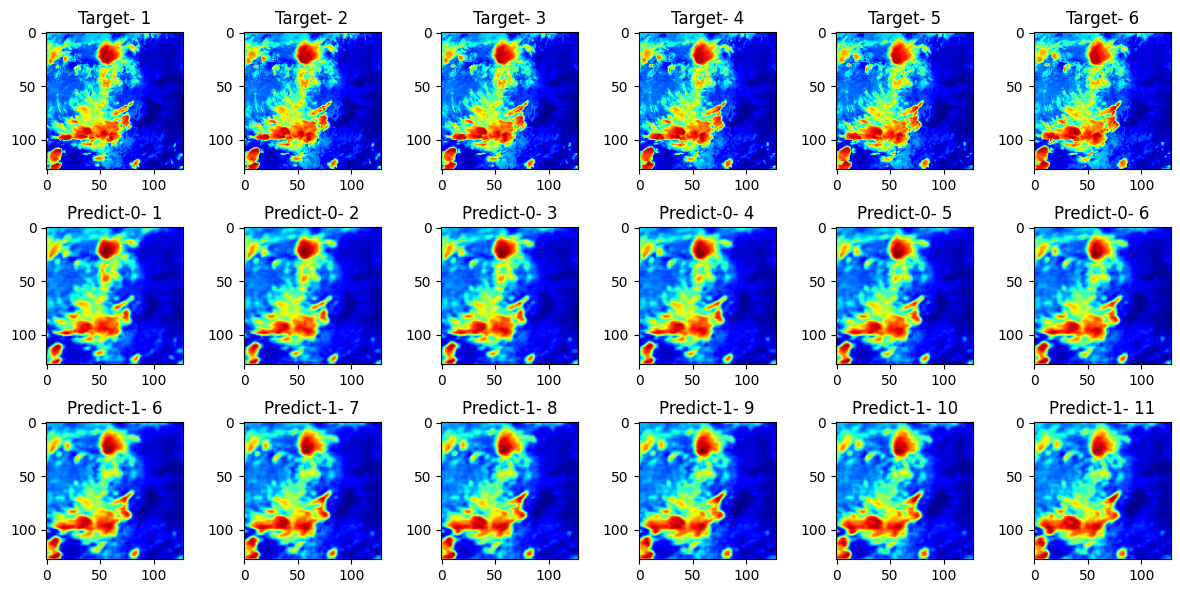

- Epoch 100-getItem(80)
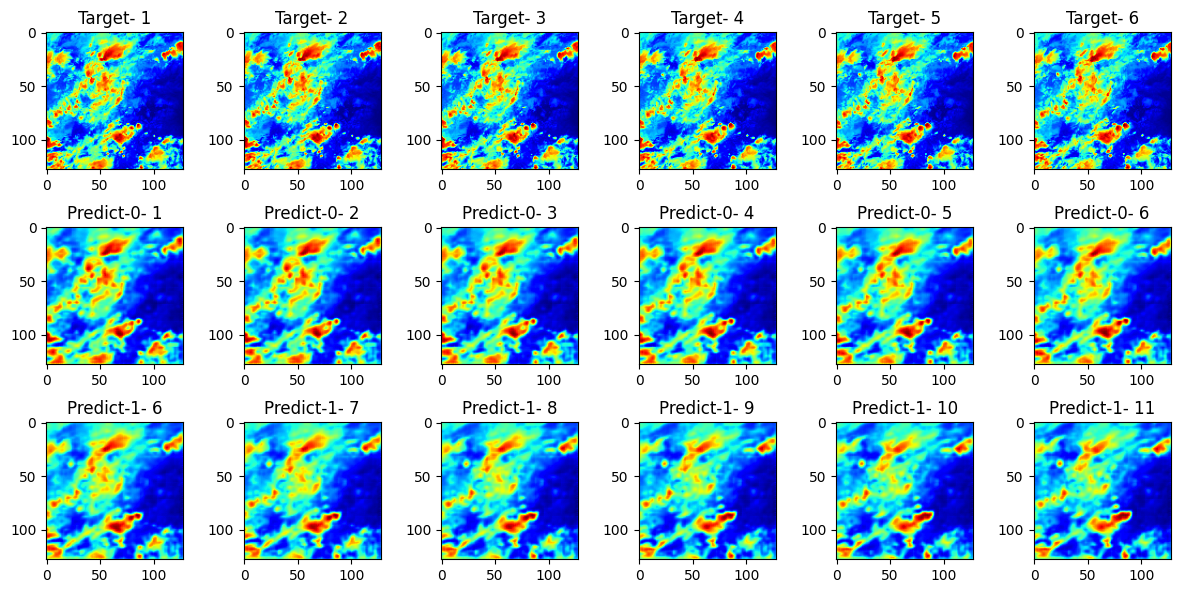

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader, TensorDataset
from torchvision import transforms
import torch.nn.functional as F
import math
import numpy as np

### 两个主要的类：PositionalEncoding和TransformerModel
- PositionalEncoding类用于为输入序列添加位置信息，这对Transformer模型很重要，因为它本身不包含序列顺序信息。
- TransformerModel类是我们的主要模型，它包含了嵌入层、位置编码、Transformer编码器和解码器。

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [3]:
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        
    def forward(self, x):
        attention = torch.sigmoid(self.conv(x))
        return x * attention

In [4]:
class CNNTransformerModel(nn.Module):
    def __init__(self, input_channels, d_model, nhead, num_layers, num_frames):
        super(CNNTransformerModel, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        # Spatial Attention
        self.attention1 = SpatialAttention(64)
        self.attention2 = SpatialAttention(128)
        self.attention3 = SpatialAttention(256)
        
        # Transformer layers
        self.embedding = nn.Linear(256 * 16 * 16, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=2048)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(d_model, 256 * 16 * 16),
            nn.ReLU(),
            nn.Unflatten(2, (256, 16, 16)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
        self.num_frames = num_frames
        
    
    
    def forward(self, src):
        # src shape: (batch_size, num_frames, channels, height, width)
        batch_size, num_frames, channels, height, width = src.shape
        src = src.view(batch_size * num_frames, channels, height, width)
        
        # CNN forward with skip connections
        x1 = self.attention1(F.relu(self.conv1(src)))
        x1_pool = F.max_pool2d(x1, 2)
        x2 = self.attention2(F.relu(self.conv2(x1_pool)))
        x2_pool = F.max_pool2d(x2, 2)
        x3 = self.attention3(F.relu(self.conv3(x2_pool)))
        x3_pool = F.max_pool2d(x3, 2)
        #print("Xs: ", x1.shape,x2.shape,x3.shape)
        #shapes:
        # x1: torch.Size([192, 64, 128, 128]) 
        # x2: torch.Size([192, 128, 64, 64]) 
        # x3: torch.Size([192, 256, 32, 32])
        
        # Reshape for Transformer
        x = x3_pool.view(batch_size, num_frames, -1)
        x = self.embedding(x)
        
        # Transformer forward
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, d_model)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # (batch_size, seq_len, d_model)
        
        # Decoder with skip connections
        x = self.decoder[0](x)
        x = self.decoder[1](x)
        x = self.decoder[2](x)
        x = x.view(batch_size * num_frames, 256, 16, 16)
        
        #print('view size', batch_size, num_frames, channels, height, width)
        x = self.decoder[3](x)
        #x = x + x3.view(batch_size * num_frames, 128, 32, 32)  # Skip connection
        
       
        x = self.decoder[4](x)
        
        x = self.decoder[5](x)
        #x = x + x2.view(batch_size * num_frames, 64, 64, 64)  # Skip connection
                
        x = self.decoder[6](x)
        
        x = self.decoder[7](x)
        #x = x + x1.view(batch_size * num_frames, channels, height, width)  # Skip connection
        x = self.decoder[8](x)
        
        return x.view(batch_size, num_frames, channels, height, width)

### Hyperparameters

In [5]:
input_channels = 1  # Assuming grayscale images
d_model = 512
nhead = 8
num_layers = 6
batch_size = 8 #16
num_epochs = 10 #0
learning_rate = 0.0001
weight_decay = 1e-5

### Create Dataset

In [6]:
class H9Dataset(Dataset):
    def __init__(self, file_path,in_len, out_len, steps, transform=None):
        self.in_len = in_len          # length of input frames
        self.out_len = out_len        # length of output frames
        self.total = in_len+out_len   # total length of both frames, this more like a moving window
        self.steps = steps            # how many frames to skip on each window moving
        
        #all tile images
        ds_list=[]
        
        ds_pos=[]
        ds_all = np.load(r'D:\Tommy\++AI\++datasets\jv_radar\batch_process_img\all_radars_rotated_flipped_normalized.npz')
        
        ds = ds_all['original']
        ds_list.append(ds)
        ds_pos.append((len(ds)-self.total) // self.steps + 1)
        
        ds = ds_all['flipped_x']
        ds_list.append(ds)
        ds_pos.append((len(ds)-self.total) // self.steps + 1)

        ds = ds_all['flipped_y']
        ds_list.append(ds)
        ds_pos.append((len(ds)-self.total) // self.steps + 1)
        
        ds = ds_all['rotated_90']
        ds_list.append(ds)
        ds_pos.append((len(ds)-self.total) // self.steps + 1)
        
        ds = ds_all['rotated_180']
        ds_list.append(ds)
        ds_pos.append((len(ds)-self.total) // self.steps + 1)
        
        ds = ds_all['rotated_270']
        ds_list.append(ds)
        ds_pos.append((len(ds)-self.total) // self.steps + 1)
        
        self.ds_list = ds_list
        self.ds_pos = ds_pos
        
        print('max number of sets', ds_pos)
        
        
        self.transform = transform

    def __len__(self):
        return sum(self.ds_pos)
    
    def __getitem__(self, i):
        num_list=0
        num_in_list = 0
        cumulative_sum = 0
        for k, length in enumerate(self.ds_pos):
            cumulative_sum += length
            if i < cumulative_sum:
                num_list,num_in_list = k, i - (cumulative_sum - length)
                break
        #print(num_list,num_in_list)
        
        ds_element = self.ds_list[num_list]
        #print(ds_element.shape)
        data_seg =  ds_element[(num_in_list)*self.steps:(num_in_list)*self.steps+self.total,:,:]
        
        data_ins = data_seg[:self.in_len,:,:]
        data_outs = data_seg[self.in_len:, :, :]#[:, np.newaxis, :, :]
        
        #Convert npmpy data to tensor
        t_inputs = torch.tensor(data_ins,dtype=torch.float32)
        t_targets = torch.tensor(data_outs,dtype=torch.float32)
        
        if self.transform:
            t_inputs = self.transform(t_inputs)
            t_targets = self.transform(t_targets)
            
        return t_inputs,t_targets

In [ ]:
# Define the transform
transform = transforms.Compose([
    transforms.Resize((128, 128))
])

train = H9Dataset(file_path ='', 
                  in_len = 12, 
                  out_len = 6,
                  steps = 6,
                  transform=None
                 )

In [ ]:
train.__len__()

In [ ]:
dsi,dso = train.__getitem__(0)
dsi.shape,dso.shape

### Assemble Data into the new data structure

In [ ]:
inputs=[]
targets=[]
for k in range(train.__len__()):
    dsi,dso = train.__getitem__(k)
    inputs.append(dsi)
    targets.append(dso)
    
input_data = np.stack(inputs)
target_data = np.stack(targets)
input_data.shape, target_data.shape

In [ ]:
input_data.min(),input_data.max(),target_data.min(),target_data.max()

#### Data structure
- Assume we have our data loaded as input_data and target_data
- input_data shape: (num_samples, 12, 128, 128)
- target_data shape: (num_samples, 6, 128, 128)

In [ ]:
# Convert NumPy arrays to PyTorch tensors
input_data = torch.from_numpy(input_data)
target_data = torch.from_numpy(target_data)
input_data.shape, target_data.shape

#### Add gray channel for image

In [ ]:
# Add a new dimension at position 2
input_data_image = input_data.unsqueeze(2)
target_data_image = target_data.unsqueeze(2)
input_data_image.shape, target_data_image.shape

### Create new Dataset and Dataloader for Transformer

In [ ]:
input_data_image.shape, target_data_image.shape

In [ ]:
# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
batch_size=1

In [ ]:
# Create DataLoader
dataset = TensorDataset(input_data_image, target_data_image)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model = CNNTransformerModel(input_channels, d_model, nhead, num_layers, num_frames=12).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

### Training loop

In [ ]:
num_epochs = 10
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_input, batch_target in dataloader:
        #print(batch_input.shape, batch_target.shape)
        batch_input = batch_input.to(device)
        batch_target = batch_target.to(device)
        
        optimizer.zero_grad()
        output = model(batch_input)
        #print('output',output.shape, batch_target.shape)
        output1=output[:,:6,:,:,:]
        loss = criterion(output1, batch_target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader)}")
    if epoch%10==0:
        np.save(f"D:/Tommy/++AI/himawari9/jvtest/models/npy_files/target_cnn_transformer_{epoch}.npy",batch_target.cpu().numpy())
        np.save(f"D:/Tommy/++AI/himawari9/jvtest/models/npy_files/predict_cnn_transformer_{epoch}.npy",output.detach().cpu().numpy())

### Save the model

In [ ]:
torch.save(model.state_dict(), r'D:\Tommy\++AI\himawari9\jvtest\models\cnn_transformer_LargeData_model_128_12_6_epoch300.pth')

### Prediction function

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNTransformerModel(input_channels, d_model, nhead, num_layers, num_frames=12).to(device)

In [ ]:
state_dict = torch.load( r'D:\Tommy\++AI\himawari9\jvtest\models\cnn_transformer_LargeData_model_128_12_6_epoch100.pth')
model.load_state_dict(state_dict)

In [ ]:
dsi,dso = train.__getitem__(40)
dsi.shape,dso.shape

In [ ]:
dsi.min(),dsi.max()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Create a figure and an array of subplots
fig, axes = plt.subplots(3, 6, figsize=(12,8))

for j in range(6):
    axes[0,j].imshow(dsi[j,:,:],cmap='jet')
    axes[0,j].set_title(f'Input- {j+1}')
for j in range(6):
    axes[1,j].imshow(dsi[j+6,:,:],cmap='jet')
    axes[1,j].set_title(f'Input- {j+7}')

for j in range(6):
    axes[2,j].imshow(dso[j,:,:],cmap='jet')
    axes[2,j].set_title(f'out- {j+1}')

plt.tight_layout()
plt.show()

In [ ]:
input_data = dsi.unsqueeze(1)
input_data.shape

In [ ]:
# Prediction function
def predict_frames(model, input_frames):
    model.eval()
    with torch.no_grad():
        input_frames = input_frames.unsqueeze(0).to(device)  # Add batch dimension
        output = model(input_frames)
    return output.squeeze(0).cpu()

In [ ]:
test_input = input_data.to(device)
test_input.shape

In [ ]:
predicted = predict_frames(model, test_input)
print(predicted.shape)  # Should be [6, 1, 128, 128]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Create a figure and an array of subplots
fig, axes = plt.subplots(3, 6, figsize=(12,6))

for j in range(6):
    axes[0,j].imshow(dso[j,:,:],cmap='jet')
    axes[0,j].set_title(f'Target- {j+1}')
for j in range(6):
    axes[1,j].imshow(predicted[j,0,:,:],cmap='jet')
    axes[1,j].set_title(f'Predict-0- {j+1}')

for j in range(6):
    axes[2,j].imshow(predicted[j+6,0,:,:],cmap='jet')
    axes[2,j].set_title(f'Predict-1- {j+6}')

plt.tight_layout()
plt.show()

### Check Training Steps

In [ ]:
t_ds = np.load(r'D:\Tommy\++AI\himawari9\jvtest\models\npy_files\target_cnn_transformer_90.npy')
p_ds = np.load(r'D:\Tommy\++AI\himawari9\jvtest\models\npy_files\predict_cnn_transformer_90.npy')
t_ds.shape, p_ds.shape

In [ ]:
#convert numpy to torch
p_ds = torch.from_numpy(p_ds)
t_ds = torch.from_numpy(t_ds)
t_ds.shape, p_ds.shape

In [ ]:
# Create a figure and an array of subplots
fig, axes = plt.subplots(2, 6, figsize=(12,4))

for j in range(6):
    axes[0,j].imshow(t_ds[0,j,0,:,:],cmap='jet')
    axes[0,j].set_title(f'Target- {j+1}')

for j in range(6):
    axes[1,j].imshow(p_ds[0,j,0,:,:],cmap='jet')
    axes[1,j].set_title(f'Predict- {j+1}')
# Adjust spacing between subplots
plt.tight_layout()
plt.show()

#### Steps

- epoch 0
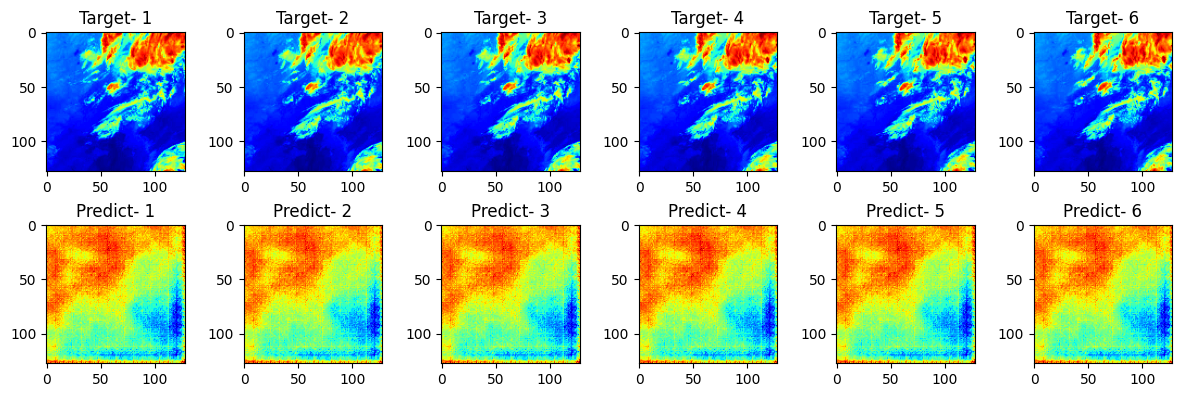

- epoch 20
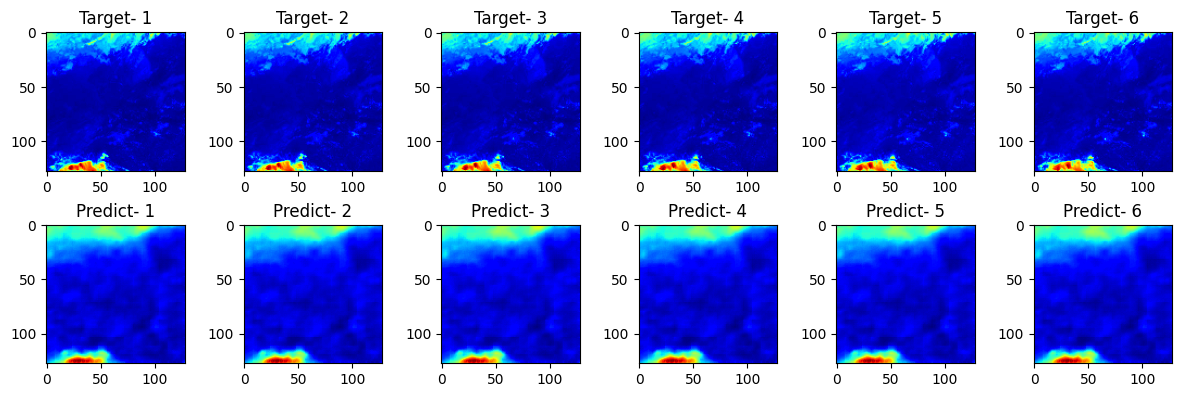

- epoch 40
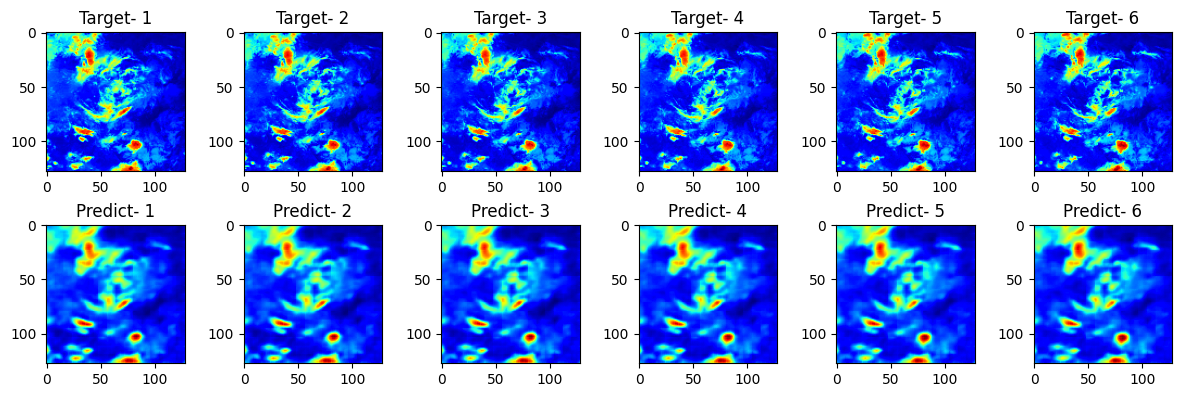

- epoch 60
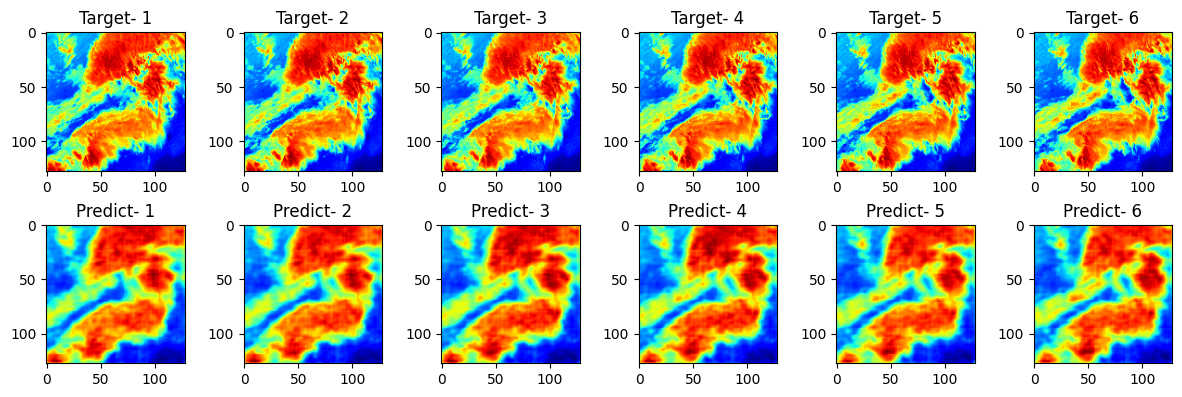

- epoch 80
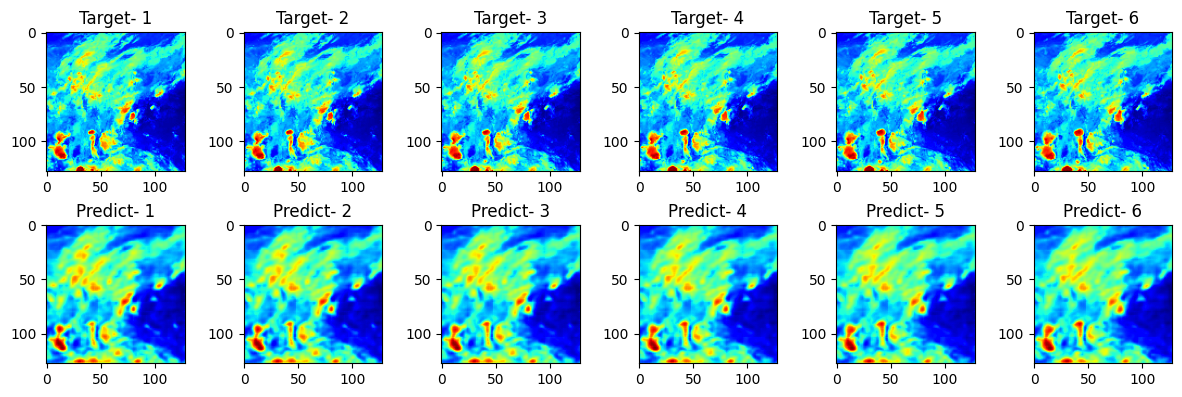

- epoch 90
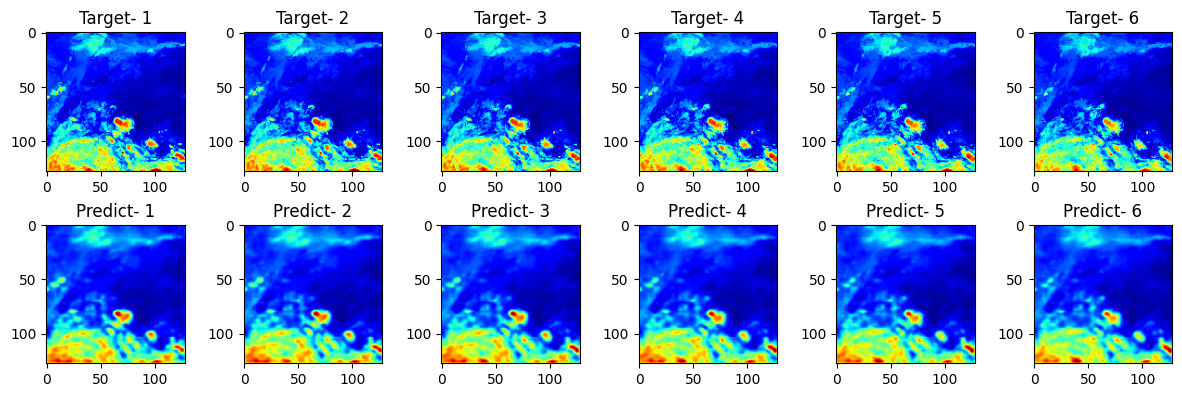